In [15]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch as t
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import re
import jieba
from collections import Counter
from openpyxl import load_workbook

from tqdm import tqdm 
 
%matplotlib inline

In [16]:
content = pd.read_excel(r"./附件1/酒店评论.xlsx",engine='openpyxl')    

label = pd.read_excel(r"./附件2/酒店评分.xlsx",engine='openpyxl')    


In [17]:

def participle(stopwords,is_filter=True,):
    all_words = []
    for idx,line in enumerate(content['评论内容']):
        if is_filter:         
            line = filter_punc(line)
       
        words = jieba.lcut(line)
        if len(words)>0:
            all_words += words
            
    dictions = {}
    cnt = Counter(all_words)
    for word,freq in cnt.items():
        if freq>1:
            if word not in stopwords:
                dictions[word] = [len(dictions),freq]
    return dictions

# 过去标点符号
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)
    return(sentence)
# 去除停用词

def move_stopwords(sentence_list, stopwords_list):
    # 去停用词
    out_list = []
    for word in sentence_list:
        if word not in stopwords_list:
#             if not remove_digits(word):
#                 continue
            if word != '\t':
                out_list.append(word)
    return out_list

#使用停用词
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

#得到分词后的词句，和对应的标签
def participle1(name,stopwords,is_filter=True):
    sentence = []
    labels=[]
    
    for j,i in enumerate(name):
        data = content.loc[content['酒店名称']==i]
        a=[label['总得分'][j],label['服务得分'][j],label['位置得分'][j],label['设施得分'][j],label['卫生得分'][j],label['性价比得分'][j]]
        for idx,line in enumerate(data['评论内容']):
            if is_filter:         
                line = filter_punc(line)
            
            words = jieba.lcut(line)
            words = move_stopwords(words,stopwords)
            if len(words)>0:
                sentence.append(words)
                labels.append(a) 
        break
    return sentence,labels
    


In [18]:
names = []
stopwords = stopwordslist('hit_stopwords.txt')
for i in list(content.groupby('酒店名称')):
    names.append(i[0])  


diction = participle(stopwords,True)
sentence,labels = participle1(names,stopwords,True)


In [19]:
# 根据单词返还单词的编码
def word2index(word,diction):
    if word in diction:
        value=diction[word][0]
    else:
        value=-1
    return(value)

# 更具编码获取对应的单词
def index2word(index,diction):
    for w,v in diction.items():
        if v[0]==index:
            return(w)
    return(None)
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence,dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l]+=1
#     return vector
    return ((1.0*vector)/len(sentence))

In [20]:
dataset=[]  #数据集
sentences=[] #原始句子
labels1=[]
j=0
for i in sentence:
    new_sentence=[]
    j+=1
    for l in i:
        if l in diction:
            new_sentence.append(word2index(l,diction))
    if len(new_sentence)!=0:
        dataset.append(sentence2vec(new_sentence,diction))
        labels1.append(labels[j-1])
    sentences.append(i)
labels=labels1

In [21]:
indices=np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]

In [22]:
test_size = len(dataset) // 10
# 训练集
train_data = dataset[2*test_size :]
train_label=labels[2*test_size :]
# 检测集
valid_data = dataset[: test_size]
valid_label = labels[: test_size]
# 测试集
test_data = dataset[test_size : 2*test_size]
test_label = labels[test_size : 2*test_size]


In [23]:
# 一个手动实现的LSTM模型，除了初始化隐含但愿部分，所有代码基本与SimpleRNN相同

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        super(SimpleLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 一个embedding层
        self.embedding = nn.Embedding(input_size, hidden_size)
        # 隐含层内部的相互链接
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input,hidden):
        # 先进行embedding层的计算，它可以把一个
        # x的尺寸：batch_size, len_seq, input_size
        x = self.embedding(input)
        # x的尺寸：batch_size, len_seq, hidden_size
        # 从输入到隐含层的计算
        output, hidden = self.lstm(x, hidden)
        # output的尺寸：batch_size, len_seq, hidden_size
        # hidden: (layer_size, batch_size, hidden_size),(layer_size, batch_size,hidden_size)
        output = output[:,-1,:]
        # output的尺寸：batch_size, hidden_size
        output = self.fc(output)
        # output的尺寸：batch_size, output_size
        # softmax函数
        output = self.softmax(output)
        return output, hidden
 
    def initHidden(self,n):
        # 对隐含单元的初始化
        # 注意尺寸是： layer_size, batch_size, hidden_size
        # 对隐单元的初始化
        # 对引单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = t.zeros(self.num_layers, n, self.hidden_size)
        # 对隐单元内部的状态cell的初始化，全0
        cell = t.zeros(self.num_layers, n, self.hidden_size)
        return (hidden, cell)



In [ ]:
# 自定义的计算一组数据分类准确度的函数
def rightness(predictions,labels):
    
    j=0
    for f in range(len(labels)):
        a=np.round(predictions[0][f].data,1).eq(np.round(labels[f].data,1))
        if a:
            j+=1
    return j,len(labels)

In [24]:
lstm = SimpleLSTM(input_size = len(diction), hidden_size = 10, output_size = 6, num_layers = 1)


# 损失函数为交叉熵

MSE = t.nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(),lr=0.001)
records=[]

losses=[]
val_losses=[]

for epoch in tqdm(range(10)):
    for i,data in enumerate(zip(train_data,train_label)):

        x = t.tensor(data[0], dtype = t.long).unsqueeze(0)
        # x尺寸：batch_size = 1, time_steps = 1, data_dimension = 1
        y = t.tensor(data[1], dtype = t.float)
        
        hidden = lstm.initHidden(len(x))
        optimizer.zero_grad()
        predict,hidden=lstm(x,hidden)
        loss = MSE(predict[0],y)
        losses.append(loss.data.numpy())

        loss.backward(retain_graph=True)

        optimizer.step()

        if i%100==0:

            rights=[]
            
            for j,val in enumerate(zip(valid_data,valid_label)):

                x = t.tensor(val[0], dtype = t.long).unsqueeze(0)
                # x尺寸：batch_size = 1, time_steps = 1, data_dimension = 1
                y = t.tensor(val[1], dtype = t.float)
                hidden = lstm.initHidden(len(x))
                predict,hidden=lstm(x,hidden)
                right = rightness(predict,y)
                rights.append(right)
                loss = MSE(predict,y)
                val_losses.append(loss.data.numpy())
            
            right_ratio=1.0*np.sum([i[0] for i in rights])/np.sum([i[1] for i in rights])
            print('第{}轮，训练损失： {:.6f}，校验损失：{:.6f}，校验准确度：{:.2f}'.format(epoch,np.mean(losses),np.mean(val_losses),right_ratio))
            records.append([np.mean(losses),np.mean(val_losses),right_ratio])

第0轮，训练损失： 20.950720，校验损失：20.935438，校验准确度：0.00
第1轮，训练损失： 13.331545，校验损失：12.167562，校验准确度：0.00
第2轮，训练损失： 6.915923，校验损失：8.114012，校验准确度：0.31
第3轮，训练损失： 4.613368，校验损失：6.086873，校验准确度：0.32
第4轮，训练损失： 3.461601，校验损失：4.870481，校验准确度：0.33
第5轮，训练损失： 2.770335，校验损失：4.059473，校验准确度：0.35
第6轮，训练损失： 2.309373，校验损失：3.480120，校验准确度：0.36
第7轮，训练损失： 1.980035，校验损失：3.045557，校验准确度：0.43
第8轮，训练损失： 1.732974，校验损失：2.707525，校验准确度：0.44
第9轮，训练损失： 1.540772，校验损失：2.437068，校验准确度：0.49
第10轮，训练损失： 1.386978，校验损失：2.215760，校验准确度：0.53
第11轮，训练损失： 1.261120，校验损失：2.031315，校验准确度：0.56
第12轮，训练损失： 1.156217，校验损失：1.875230，校验准确度：0.59
第13轮，训练损失： 1.067435，校验损失：1.741428，校验准确度：0.62
第14轮，训练损失： 0.991322，校验损失：1.625453，校验准确度：0.66
第15轮，训练损失： 0.925346，校验损失：1.523966，校验准确度：0.69
第16轮，训练损失： 0.867606，校验损失：1.434409，校验准确度：0.72
第17轮，训练损失： 0.816652，校验损失：1.354796，校验准确度：0.77
第18轮，训练损失： 0.771351，校验损失：1.283557，校验准确度：0.78
第19轮，训练损失： 0.730814，校验损失：1.219437，校验准确度：0.79
第20轮，训练损失： 0.694325，校验损失：1.161418，校验准确度：0.84
第21轮，训练损失： 0.661307，校验损失：1.108670，校验准确度：0.85
第22轮，训练损失： 0.631

In [25]:
for i,data in enumerate(zip(test_data,test_label)):
    x,y=data
    x=Variable(t.FloatTensor(x).view(1,-1))
    y=Variable(t.FloatTensor(np.array([y])))
    predict = model(x)
    right = rightness(predict,y)
    np.round(predict.data,1)
    print(np.round(predict.data,1))
    print(y)
    print('----------------------------------------------------')

tensor([[4.7000, 4.8000, 4.8000, 4.6000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
---------------------------

tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
----------------------------------------------------
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
tensor([[4.8000, 4.8000, 4.8000, 4.7000, 4.8000, 4.0000]])
---------------------------

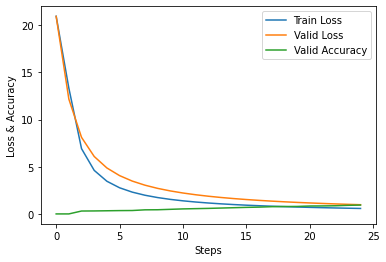

In [26]:
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [29]:
t.save(model, 'model2.pkl')